In [7]:
import os

import pandas as pd
import numpy as np

import time

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col
import pyspark.sql.functions as sf
import pyspark.sql.types as st
from pyspark.ml.recommendation import ALS
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes, FMClassifier
from pyspark.ml import Pipeline, PipelineModel
from sim4rec.modules import Simulator

from replay.metrics import NDCG, Precision, RocAuc, Metric
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
from replay.data_preparator import Indexer

from sim4rec.utils import pandas_to_spark, VectorElementExtractor
from sim4rec.modules import RealDataGenerator, SDVDataGenerator
from sim4rec.modules import evaluate_synthetic, EvaluateMetrics
from sim4rec.response import ParametricResponseFunction, BernoulliResponse, NoiseResponse

from replay.models import UCB, ItemKNN
from replay.models import RandomRec

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

spark = SparkSession.builder\
    .appName('simulator_movielens')\
    .master('local[*]')\
    .config('spark.sql.shuffle.partitions', '192')\
    .config('spark.default.parallelism', '192')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.sql.autoBroadcastJoinThreshold', '-1')\
    .config('spark.driver.memory', '256g')\
    .getOrCreate()
spark.sparkContext.setLogLevel('ERROR')

In [8]:
USER_SCHEMA = st.StructType(
    [st.StructField('user_idx', st.IntegerType())] +\
    [st.StructField(f'uembed_{i}', st.DoubleType()) for i in range(64)]
)
ITEM_SCHEMA = st.StructType(
    [st.StructField('item_idx', st.IntegerType())] +\
    [st.StructField(f'iembed_{i}', st.DoubleType()) for i in range(64)]
)
LOG_SCHEMA = st.StructType([
    st.StructField('user_idx', st.IntegerType()),
    st.StructField('item_idx', st.IntegerType()),
    st.StructField('relevance', st.DoubleType()),
    st.StructField('timestamp', st.IntegerType())
])

users_df_train = spark.read.csv('user_svd.csv', header=True, schema=USER_SCHEMA)
items_df_train = spark.read.csv('item_svd.csv', header=True, schema=ITEM_SCHEMA)
log_df_train   = spark.read.csv('train/rating.csv', header=True, schema=LOG_SCHEMA)

users_df_train = users_df_train.withColumnRenamed("user_idx", "user_id")
items_df_train = items_df_train.withColumnRenamed("item_idx", "item_id")
log_df_train = log_df_train.withColumnRenamed("user_idx", "user_id")
log_df_train = log_df_train.withColumnRenamed("item_idx", "item_id")

log_df_train = log_df_train.join(users_df_train, log_df_train['user_id'] == users_df_train['user_id'], 'leftsemi')
log_df_train = log_df_train.join(items_df_train, log_df_train['item_id'] == items_df_train['item_id'], 'leftsemi')

for c in users_df_train.columns[1:]:
    users_df_train = users_df_train.withColumnRenamed(c, 'user_' + c)
    
for c in items_df_train.columns[1:]:
    items_df_train = items_df_train.withColumnRenamed(c, 'item_' + c)

avg_item_ratings = log_df_train.groupBy('item_id').agg(sf.avg(sf.col('relevance')).alias('item_rating_avg'))

log_df_train = log_df_train.withColumn(
    'relevance', sf.when(sf.col('relevance') > 3, 1).otherwise(0))

users_df_train = users_df_train.cache()
items_df_train = items_df_train.cache()
log_df_train = log_df_train.cache()

print(users_df_train.count())
print(items_df_train.count())
print(log_df_train.count())

80650
8267
10000132


In [10]:
users_df_val = spark.read.csv('user_svd.csv', header=True, schema=USER_SCHEMA)
items_df_val = spark.read.csv('item_svd.csv', header=True, schema=ITEM_SCHEMA)
log_df_val   = spark.read.csv('val/rating.csv', header=True, schema=LOG_SCHEMA)

users_df_val = users_df_val.withColumnRenamed("user_idx", "user_id")
items_df_val = items_df_val.withColumnRenamed("item_idx", "item_id")
log_df_val = log_df_val.withColumnRenamed("user_idx", "user_id")
log_df_val = log_df_val.withColumnRenamed("item_idx", "item_id")

log_df_val = log_df_val.join(users_df_val, log_df_val['user_id'] == users_df_val['user_id'], 'leftsemi')
log_df_val = log_df_val.join(items_df_val, log_df_val['item_id'] == items_df_val['item_id'], 'leftsemi')

for c in users_df_val.columns[1:]:
    users_df_val = users_df_val.withColumnRenamed(c, 'user_' + c)

for c in items_df_val.columns[1:]:
    items_df_val = items_df_val.withColumnRenamed(c, 'item_' + c)

log_df_val = log_df_val.withColumn(
    'relevance', sf.when(sf.col('relevance') > 3, 1).otherwise(0))

users_df_val = users_df_val.cache()
items_df_val = items_df_val.cache()
log_df_val = log_df_val.cache()

print(users_df_val.count())
print(items_df_val.count())
print(log_df_val.count())

80650
8267


402507


In [11]:
items_generator = RealDataGenerator(label='items_real', seed=1234)

users_generator = SDVDataGenerator(
    label='synth',
    id_column_name='user_id',
    model_name='gaussiancopula',
    parallelization_level=4,
    device_name='cpu',
    seed=1234
)

users_generator.fit(users_df_train.drop('user_id'))
items_generator.fit(items_df_train)

real_users = users_df_train.sample(0.12)
syn_users = users_generator.generate(real_users.count())
_ = items_generator.generate(items_df_train.select('item_id').distinct().count())

train_df = log_df_train.join(users_df_train, 'user_id', 'left')\
                     .join(items_df_train, 'item_id', 'left')\
                     .drop('timestamp')
train_df = train_df.na.drop()

val_df = log_df_val.join(users_df_val, 'user_id', 'left')\
                     .join(items_df_val, 'item_id', 'left')\
                     .drop('timestamp')
val_df = val_df.na.drop()
val_df.count()

402507

In [12]:
va = VectorAssembler(
    inputCols=users_df_train.columns[1:] + items_df_train.columns[1:],
    outputCol='features'
)

fm = FMClassifier(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='proba'
)

rf = RandomForestClassifier(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='proba'
)

lr = LogisticRegression(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='proba'
)

lr_model = lr.fit(va.transform(train_df))
rf_model = rf.fit(va.transform(train_df))
fm_model = fm.fit(va.transform(train_df))
vee = VectorElementExtractor(inputCol='proba', outputCol='scores', index=1)
mc = ParametricResponseFunction(inputCols=['scores'], outputCol='__pr', weights=[0.25])
br = BernoulliResponse(inputCol='__pr', outputCol='response', seed=1234)
pipeline_lr = PipelineModel(stages=[va, lr_model, vee, mc, br])
pipeline_rf = PipelineModel(stages=[va, rf_model, vee, mc, br])
pipeline_fm = PipelineModel(stages=[va, fm_model, vee, mc, br])

noise_resp = NoiseResponse(mu=0.5, sigma=0.2, outputCol='__noise')
br = BernoulliResponse(inputCol='__noise', outputCol='response')
pipeline_rand = PipelineModel(stages=[noise_resp, br])

In [15]:
def get_baseline(test_df):
    pred_df = test_df.merge(avg_item_ratings.toPandas(), on='item_id', how='inner')
    pred_df['baseline'] = (pred_df['item_rating_avg']-pred_df['item_rating_avg'].min())/(pred_df['item_rating_avg'].max()-pred_df['item_rating_avg'].min())
    pred_df['baseline_bin'] = np.where(pred_df['baseline'] > 0.5, 1, 0) 
    print(f"ROC AUC (baseline): {roc_auc_score(pred_df.relevance, pred_df.baseline)}")
    print(f"Precision (baseline): {precision_score(pred_df.relevance, pred_df.baseline_bin)}")
    print(f"Recall (baseline): {recall_score(pred_df.relevance, pred_df.baseline_bin)}")
    print(f"Accuracy (baseline): {accuracy_score(pred_df.relevance, pred_df.baseline_bin)}")
    print()

def assess_models(model, test_df):
    pred_df = model.transform(test_df).select("user_id", "item_id", "relevance", "scores").toPandas()
    pred_df['response_bin'] = np.where(pred_df['scores'] > 0.5, 1, 0)
    print(f"ROC AUC (classificator): {roc_auc_score(pred_df.relevance, pred_df.scores)}")
    print(f"Precision (classificator): {precision_score(pred_df.relevance, pred_df.response_bin)}")
    print(f"Recall (classificator): {recall_score(pred_df.relevance, pred_df.response_bin)}")
    print(f"Accuracy (classificator): {accuracy_score(pred_df.relevance, pred_df.response_bin)}")
    print()

get_baseline(val_df)
assess_models(pipeline_lr, val_df)
assess_models(pipeline_rf, val_df)
assess_models(pipeline_fm, val_df)

ROC AUC (baseline): 0.7364567206633343
ROC AUC (classificator): 0.5414111941477786
Precision (baseline): 0.6667442887541655
Precision (classificator): 0.6414003260643594
Recall (baseline): 0.9775066612774741
Recall (classificator): 0.9201313811898866
Accuracy (baseline): 0.676432956445478
Accuracy (classificator): 0.623740705130594



ROC AUC (baseline): 0.7364567206633343
ROC AUC (classificator): 0.5979397964860597
Precision (baseline): 0.6667442887541655
Precision (classificator): 0.6397484537962405
Recall (baseline): 0.9775066612774741
Recall (classificator): 0.9912334056688551
Accuracy (baseline): 0.676432956445478
Accuracy (classificator): 0.6410621430186307



ROC AUC (baseline): 0.7364567206633343
ROC AUC (classificator): 0.6049908830376873
Precision (baseline): 0.6667442887541655
Precision (classificator): 0.67158745675794
Recall (baseline): 0.9775066612774741
Recall (classificator): 0.8006757419623202
Accuracy (baseline): 0.676432956445478
Accuracy (classificator): 0.6259195492252309



AnalysisException: Column 'scores' does not exist. Did you mean one of the following? [__noise, response, user_id, item_id, relevance, user_uembed_0, user_uembed_1, user_uembed_2, user_uembed_3, user_uembed_4, user_uembed_5, user_uembed_6, user_uembed_7, user_uembed_8, user_uembed_9, item_iembed_0, item_iembed_1, item_iembed_2, item_iembed_3, item_iembed_4, item_iembed_5, item_iembed_6, item_iembed_7, item_iembed_8, item_iembed_9, user_uembed_10, user_uembed_11, user_uembed_12, user_uembed_13, user_uembed_14, user_uembed_15, user_uembed_16, user_uembed_17, user_uembed_18, user_uembed_19, user_uembed_20, user_uembed_21, user_uembed_22, user_uembed_23, user_uembed_24, user_uembed_25, user_uembed_26, user_uembed_27, user_uembed_28, user_uembed_29, user_uembed_30, user_uembed_31, user_uembed_32, user_uembed_33, user_uembed_34, user_uembed_35, user_uembed_36, user_uembed_37, user_uembed_38, user_uembed_39, user_uembed_40, user_uembed_41, user_uembed_42, user_uembed_43, user_uembed_44, user_uembed_45, user_uembed_46, user_uembed_47, user_uembed_48, user_uembed_49, user_uembed_50, user_uembed_51, user_uembed_52, user_uembed_53, user_uembed_54, user_uembed_55, user_uembed_56, user_uembed_57, user_uembed_58, user_uembed_59, user_uembed_60, user_uembed_61, user_uembed_62, user_uembed_63, item_iembed_10, item_iembed_11, item_iembed_12, item_iembed_13, item_iembed_14, item_iembed_15, item_iembed_16, item_iembed_17, item_iembed_18, item_iembed_19, item_iembed_20, item_iembed_21, item_iembed_22, item_iembed_23, item_iembed_24, item_iembed_25, item_iembed_26, item_iembed_27, item_iembed_28, item_iembed_29, item_iembed_30, item_iembed_31, item_iembed_32, item_iembed_33, item_iembed_34, item_iembed_35, item_iembed_36, item_iembed_37, item_iembed_38, item_iembed_39, item_iembed_40, item_iembed_41, item_iembed_42, item_iembed_43, item_iembed_44, item_iembed_45, item_iembed_46, item_iembed_47, item_iembed_48, item_iembed_49, item_iembed_50, item_iembed_51, item_iembed_52, item_iembed_53, item_iembed_54, item_iembed_55, item_iembed_56, item_iembed_57, item_iembed_58, item_iembed_59, item_iembed_60, item_iembed_61, item_iembed_62, item_iembed_63];
'Project [user_id#26093, item_id#26099, relevance#34568, 'scores]
+- Project [item_id#26099, user_id#26093, relevance#34568, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, ... 109 more fields]
   +- Project [item_id#26099, user_id#26093, relevance#34568, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, ... 108 more fields]
      +- Filter atleastnnonnulls(131, item_id#26099, user_id#26093, relevance#34568, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, ... 108 more fields)
         +- Project [item_id#26099, user_id#26093, relevance#34568, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, ... 107 more fields]
            +- Project [item_id#26099, user_id#26093, relevance#34568, timestamp#25954, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, ... 108 more fields]
               +- Join LeftOuter, (item_id#26099 = item_id#26026)
                  :- Project [user_id#26093, item_id#26099, relevance#34568, timestamp#25954, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, ... 44 more fields]
                  :  +- Join LeftOuter, (user_id#26093 = user_id#25959)
                  :     :- Project [user_id#26093, item_id#26099, CASE WHEN (relevance#25953 > cast(3 as double)) THEN 1 ELSE 0 END AS relevance#34568, timestamp#25954]
                  :     :  +- Join LeftSemi, (item_id#26099 = item_id#26026)
                  :     :     :- Join LeftSemi, (user_id#26093 = user_id#25959)
                  :     :     :  :- Project [user_id#26093, item_idx#25952 AS item_id#26099, relevance#25953, timestamp#25954]
                  :     :     :  :  +- Project [user_idx#25951 AS user_id#26093, item_idx#25952, relevance#25953, timestamp#25954]
                  :     :     :  :     +- Relation [user_idx#25951,item_idx#25952,relevance#25953,timestamp#25954] csv
                  :     :     :  +- Project [user_idx#25691 AS user_id#25959, uembed_0#25692, uembed_1#25693, uembed_2#25694, uembed_3#25695, uembed_4#25696, uembed_5#25697, uembed_6#25698, uembed_7#25699, uembed_8#25700, uembed_9#25701, uembed_10#25702, uembed_11#25703, uembed_12#25704, uembed_13#25705, uembed_14#25706, uembed_15#25707, uembed_16#25708, uembed_17#25709, uembed_18#25710, uembed_19#25711, uembed_20#25712, uembed_21#25713, uembed_22#25714, ... 41 more fields]
                  :     :     :     +- Relation [user_idx#25691,uembed_0#25692,uembed_1#25693,uembed_2#25694,uembed_3#25695,uembed_4#25696,uembed_5#25697,uembed_6#25698,uembed_7#25699,uembed_8#25700,uembed_9#25701,uembed_10#25702,uembed_11#25703,uembed_12#25704,uembed_13#25705,uembed_14#25706,uembed_15#25707,uembed_16#25708,uembed_17#25709,uembed_18#25710,uembed_19#25711,uembed_20#25712,uembed_21#25713,uembed_22#25714,... 41 more fields] csv
                  :     :     +- Project [item_idx#25821 AS item_id#26026, iembed_0#25822, iembed_1#25823, iembed_2#25824, iembed_3#25825, iembed_4#25826, iembed_5#25827, iembed_6#25828, iembed_7#25829, iembed_8#25830, iembed_9#25831, iembed_10#25832, iembed_11#25833, iembed_12#25834, iembed_13#25835, iembed_14#25836, iembed_15#25837, iembed_16#25838, iembed_17#25839, iembed_18#25840, iembed_19#25841, iembed_20#25842, iembed_21#25843, iembed_22#25844, ... 41 more fields]
                  :     :        +- Relation [item_idx#25821,iembed_0#25822,iembed_1#25823,iembed_2#25824,iembed_3#25825,iembed_4#25826,iembed_5#25827,iembed_6#25828,iembed_7#25829,iembed_8#25830,iembed_9#25831,iembed_10#25832,iembed_11#25833,iembed_12#25834,iembed_13#25835,iembed_14#25836,iembed_15#25837,iembed_16#25838,iembed_17#25839,iembed_18#25840,iembed_19#25841,iembed_20#25842,iembed_21#25843,iembed_22#25844,... 41 more fields] csv
                  :     +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :        +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :           +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :              +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                 +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                    +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                       +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                          +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                             +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                                +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                                   +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                                      +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                                         +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                                            +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                                               +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                                                  +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                                                     +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                                                        +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                                                           +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                                                              +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                                                                 +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                                                                    +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                                                                       +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                                                                          +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                                                                             +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                                                                                +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                                                                                   +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                                                                                      +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                                                                                         +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                                                                                            +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                                                                                               +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                                                                                                  +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                                                                                                     +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                                                                                                        +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                                                                                                           +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                                                                                                              +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                                                                                                                 +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                                                                                                                    +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                                                                                                                       +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                                                                                                                          +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                                                                                                                             +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, user_uembed_22#27572, ... 41 more fields]
                  :                                                                                                                                +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, user_uembed_21#27506, uembed_22#50257 AS user_uembed_22#27572, ... 41 more fields]
                  :                                                                                                                                   +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, user_uembed_20#27440, uembed_21#50256 AS user_uembed_21#27506, uembed_22#50257, ... 41 more fields]
                  :                                                                                                                                      +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, user_uembed_19#27374, uembed_20#50255 AS user_uembed_20#27440, uembed_21#50256, uembed_22#50257, ... 41 more fields]
                  :                                                                                                                                         +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, user_uembed_18#27308, uembed_19#50254 AS user_uembed_19#27374, uembed_20#50255, uembed_21#50256, uembed_22#50257, ... 41 more fields]
                  :                                                                                                                                            +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, user_uembed_17#27242, uembed_18#50253 AS user_uembed_18#27308, uembed_19#50254, uembed_20#50255, uembed_21#50256, uembed_22#50257, ... 41 more fields]
                  :                                                                                                                                               +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, user_uembed_16#27176, uembed_17#50252 AS user_uembed_17#27242, uembed_18#50253, uembed_19#50254, uembed_20#50255, uembed_21#50256, uembed_22#50257, ... 41 more fields]
                  :                                                                                                                                                  +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, user_uembed_15#27110, uembed_16#50251 AS user_uembed_16#27176, uembed_17#50252, uembed_18#50253, uembed_19#50254, uembed_20#50255, uembed_21#50256, uembed_22#50257, ... 41 more fields]
                  :                                                                                                                                                     +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, user_uembed_14#27044, uembed_15#50250 AS user_uembed_15#27110, uembed_16#50251, uembed_17#50252, uembed_18#50253, uembed_19#50254, uembed_20#50255, uembed_21#50256, uembed_22#50257, ... 41 more fields]
                  :                                                                                                                                                        +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, user_uembed_13#26978, uembed_14#50249 AS user_uembed_14#27044, uembed_15#50250, uembed_16#50251, uembed_17#50252, uembed_18#50253, uembed_19#50254, uembed_20#50255, uembed_21#50256, uembed_22#50257, ... 41 more fields]
                  :                                                                                                                                                           +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, user_uembed_12#26912, uembed_13#50248 AS user_uembed_13#26978, uembed_14#50249, uembed_15#50250, uembed_16#50251, uembed_17#50252, uembed_18#50253, uembed_19#50254, uembed_20#50255, uembed_21#50256, uembed_22#50257, ... 41 more fields]
                  :                                                                                                                                                              +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, user_uembed_11#26846, uembed_12#50247 AS user_uembed_12#26912, uembed_13#50248, uembed_14#50249, uembed_15#50250, uembed_16#50251, uembed_17#50252, uembed_18#50253, uembed_19#50254, uembed_20#50255, uembed_21#50256, uembed_22#50257, ... 41 more fields]
                  :                                                                                                                                                                 +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, user_uembed_10#26780, uembed_11#50246 AS user_uembed_11#26846, uembed_12#50247, uembed_13#50248, uembed_14#50249, uembed_15#50250, uembed_16#50251, uembed_17#50252, uembed_18#50253, uembed_19#50254, uembed_20#50255, uembed_21#50256, uembed_22#50257, ... 41 more fields]
                  :                                                                                                                                                                    +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, user_uembed_9#26714, uembed_10#50245 AS user_uembed_10#26780, uembed_11#50246, uembed_12#50247, uembed_13#50248, uembed_14#50249, uembed_15#50250, uembed_16#50251, uembed_17#50252, uembed_18#50253, uembed_19#50254, uembed_20#50255, uembed_21#50256, uembed_22#50257, ... 41 more fields]
                  :                                                                                                                                                                       +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, user_uembed_8#26648, uembed_9#50244 AS user_uembed_9#26714, uembed_10#50245, uembed_11#50246, uembed_12#50247, uembed_13#50248, uembed_14#50249, uembed_15#50250, uembed_16#50251, uembed_17#50252, uembed_18#50253, uembed_19#50254, uembed_20#50255, uembed_21#50256, uembed_22#50257, ... 41 more fields]
                  :                                                                                                                                                                          +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, user_uembed_7#26582, uembed_8#50243 AS user_uembed_8#26648, uembed_9#50244, uembed_10#50245, uembed_11#50246, uembed_12#50247, uembed_13#50248, uembed_14#50249, uembed_15#50250, uembed_16#50251, uembed_17#50252, uembed_18#50253, uembed_19#50254, uembed_20#50255, uembed_21#50256, uembed_22#50257, ... 41 more fields]
                  :                                                                                                                                                                             +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, user_uembed_6#26516, uembed_7#50242 AS user_uembed_7#26582, uembed_8#50243, uembed_9#50244, uembed_10#50245, uembed_11#50246, uembed_12#50247, uembed_13#50248, uembed_14#50249, uembed_15#50250, uembed_16#50251, uembed_17#50252, uembed_18#50253, uembed_19#50254, uembed_20#50255, uembed_21#50256, uembed_22#50257, ... 41 more fields]
                  :                                                                                                                                                                                +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, user_uembed_5#26450, uembed_6#50241 AS user_uembed_6#26516, uembed_7#50242, uembed_8#50243, uembed_9#50244, uembed_10#50245, uembed_11#50246, uembed_12#50247, uembed_13#50248, uembed_14#50249, uembed_15#50250, uembed_16#50251, uembed_17#50252, uembed_18#50253, uembed_19#50254, uembed_20#50255, uembed_21#50256, uembed_22#50257, ... 41 more fields]
                  :                                                                                                                                                                                   +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, user_uembed_4#26384, uembed_5#50240 AS user_uembed_5#26450, uembed_6#50241, uembed_7#50242, uembed_8#50243, uembed_9#50244, uembed_10#50245, uembed_11#50246, uembed_12#50247, uembed_13#50248, uembed_14#50249, uembed_15#50250, uembed_16#50251, uembed_17#50252, uembed_18#50253, uembed_19#50254, uembed_20#50255, uembed_21#50256, uembed_22#50257, ... 41 more fields]
                  :                                                                                                                                                                                      +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, user_uembed_3#26318, uembed_4#50239 AS user_uembed_4#26384, uembed_5#50240, uembed_6#50241, uembed_7#50242, uembed_8#50243, uembed_9#50244, uembed_10#50245, uembed_11#50246, uembed_12#50247, uembed_13#50248, uembed_14#50249, uembed_15#50250, uembed_16#50251, uembed_17#50252, uembed_18#50253, uembed_19#50254, uembed_20#50255, uembed_21#50256, uembed_22#50257, ... 41 more fields]
                  :                                                                                                                                                                                         +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, user_uembed_2#26252, uembed_3#50238 AS user_uembed_3#26318, uembed_4#50239, uembed_5#50240, uembed_6#50241, uembed_7#50242, uembed_8#50243, uembed_9#50244, uembed_10#50245, uembed_11#50246, uembed_12#50247, uembed_13#50248, uembed_14#50249, uembed_15#50250, uembed_16#50251, uembed_17#50252, uembed_18#50253, uembed_19#50254, uembed_20#50255, uembed_21#50256, uembed_22#50257, ... 41 more fields]
                  :                                                                                                                                                                                            +- Project [user_id#25959, user_uembed_0#26120, user_uembed_1#26186, uembed_2#50237 AS user_uembed_2#26252, uembed_3#50238, uembed_4#50239, uembed_5#50240, uembed_6#50241, uembed_7#50242, uembed_8#50243, uembed_9#50244, uembed_10#50245, uembed_11#50246, uembed_12#50247, uembed_13#50248, uembed_14#50249, uembed_15#50250, uembed_16#50251, uembed_17#50252, uembed_18#50253, uembed_19#50254, uembed_20#50255, uembed_21#50256, uembed_22#50257, ... 41 more fields]
                  :                                                                                                                                                                                               +- Project [user_id#25959, user_uembed_0#26120, uembed_1#50236 AS user_uembed_1#26186, uembed_2#50237, uembed_3#50238, uembed_4#50239, uembed_5#50240, uembed_6#50241, uembed_7#50242, uembed_8#50243, uembed_9#50244, uembed_10#50245, uembed_11#50246, uembed_12#50247, uembed_13#50248, uembed_14#50249, uembed_15#50250, uembed_16#50251, uembed_17#50252, uembed_18#50253, uembed_19#50254, uembed_20#50255, uembed_21#50256, uembed_22#50257, ... 41 more fields]
                  :                                                                                                                                                                                                  +- Project [user_id#25959, uembed_0#50235 AS user_uembed_0#26120, uembed_1#50236, uembed_2#50237, uembed_3#50238, uembed_4#50239, uembed_5#50240, uembed_6#50241, uembed_7#50242, uembed_8#50243, uembed_9#50244, uembed_10#50245, uembed_11#50246, uembed_12#50247, uembed_13#50248, uembed_14#50249, uembed_15#50250, uembed_16#50251, uembed_17#50252, uembed_18#50253, uembed_19#50254, uembed_20#50255, uembed_21#50256, uembed_22#50257, ... 41 more fields]
                  :                                                                                                                                                                                                     +- Project [user_idx#50234 AS user_id#25959, uembed_0#50235, uembed_1#50236, uembed_2#50237, uembed_3#50238, uembed_4#50239, uembed_5#50240, uembed_6#50241, uembed_7#50242, uembed_8#50243, uembed_9#50244, uembed_10#50245, uembed_11#50246, uembed_12#50247, uembed_13#50248, uembed_14#50249, uembed_15#50250, uembed_16#50251, uembed_17#50252, uembed_18#50253, uembed_19#50254, uembed_20#50255, uembed_21#50256, uembed_22#50257, ... 41 more fields]
                  :                                                                                                                                                                                                        +- Relation [user_idx#50234,uembed_0#50235,uembed_1#50236,uembed_2#50237,uembed_3#50238,uembed_4#50239,uembed_5#50240,uembed_6#50241,uembed_7#50242,uembed_8#50243,uembed_9#50244,uembed_10#50245,uembed_11#50246,uembed_12#50247,uembed_13#50248,uembed_14#50249,uembed_15#50250,uembed_16#50251,uembed_17#50252,uembed_18#50253,uembed_19#50254,uembed_20#50255,uembed_21#50256,uembed_22#50257,... 41 more fields] csv
                  +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                     +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                        +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                           +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                              +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                 +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                    +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                       +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                          +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                             +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                                +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                                   +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                                      +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                                         +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                                            +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                                               +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                                                  +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                                                     +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                                                        +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                                                           +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                                                              +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                                                                 +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                                                                    +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                                                                       +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                                                                          +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                                                                             +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                                                                                +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                                                                                   +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                                                                                      +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                                                                                         +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                                                                                            +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                                                                                               +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                                                                                                  +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                                                                                                     +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                                                                                                        +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                                                                                                           +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                                                                                                              +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                                                                                                                 +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                                                                                                                    +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                                                                                                                       +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                                                                                                                          +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, item_iembed_22#31796, ... 41 more fields]
                                                                                                                                             +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, item_iembed_21#31730, iembed_22#50391 AS item_iembed_22#31796, ... 41 more fields]
                                                                                                                                                +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, item_iembed_20#31664, iembed_21#50390 AS item_iembed_21#31730, iembed_22#50391, ... 41 more fields]
                                                                                                                                                   +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, item_iembed_19#31598, iembed_20#50389 AS item_iembed_20#31664, iembed_21#50390, iembed_22#50391, ... 41 more fields]
                                                                                                                                                      +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, item_iembed_18#31532, iembed_19#50388 AS item_iembed_19#31598, iembed_20#50389, iembed_21#50390, iembed_22#50391, ... 41 more fields]
                                                                                                                                                         +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, item_iembed_17#31466, iembed_18#50387 AS item_iembed_18#31532, iembed_19#50388, iembed_20#50389, iembed_21#50390, iembed_22#50391, ... 41 more fields]
                                                                                                                                                            +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, item_iembed_16#31400, iembed_17#50386 AS item_iembed_17#31466, iembed_18#50387, iembed_19#50388, iembed_20#50389, iembed_21#50390, iembed_22#50391, ... 41 more fields]
                                                                                                                                                               +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, item_iembed_15#31334, iembed_16#50385 AS item_iembed_16#31400, iembed_17#50386, iembed_18#50387, iembed_19#50388, iembed_20#50389, iembed_21#50390, iembed_22#50391, ... 41 more fields]
                                                                                                                                                                  +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, item_iembed_14#31268, iembed_15#50384 AS item_iembed_15#31334, iembed_16#50385, iembed_17#50386, iembed_18#50387, iembed_19#50388, iembed_20#50389, iembed_21#50390, iembed_22#50391, ... 41 more fields]
                                                                                                                                                                     +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, item_iembed_13#31202, iembed_14#50383 AS item_iembed_14#31268, iembed_15#50384, iembed_16#50385, iembed_17#50386, iembed_18#50387, iembed_19#50388, iembed_20#50389, iembed_21#50390, iembed_22#50391, ... 41 more fields]
                                                                                                                                                                        +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, item_iembed_12#31136, iembed_13#50382 AS item_iembed_13#31202, iembed_14#50383, iembed_15#50384, iembed_16#50385, iembed_17#50386, iembed_18#50387, iembed_19#50388, iembed_20#50389, iembed_21#50390, iembed_22#50391, ... 41 more fields]
                                                                                                                                                                           +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, item_iembed_11#31070, iembed_12#50381 AS item_iembed_12#31136, iembed_13#50382, iembed_14#50383, iembed_15#50384, iembed_16#50385, iembed_17#50386, iembed_18#50387, iembed_19#50388, iembed_20#50389, iembed_21#50390, iembed_22#50391, ... 41 more fields]
                                                                                                                                                                              +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, item_iembed_10#31004, iembed_11#50380 AS item_iembed_11#31070, iembed_12#50381, iembed_13#50382, iembed_14#50383, iembed_15#50384, iembed_16#50385, iembed_17#50386, iembed_18#50387, iembed_19#50388, iembed_20#50389, iembed_21#50390, iembed_22#50391, ... 41 more fields]
                                                                                                                                                                                 +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, item_iembed_9#30938, iembed_10#50379 AS item_iembed_10#31004, iembed_11#50380, iembed_12#50381, iembed_13#50382, iembed_14#50383, iembed_15#50384, iembed_16#50385, iembed_17#50386, iembed_18#50387, iembed_19#50388, iembed_20#50389, iembed_21#50390, iembed_22#50391, ... 41 more fields]
                                                                                                                                                                                    +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, item_iembed_8#30872, iembed_9#50378 AS item_iembed_9#30938, iembed_10#50379, iembed_11#50380, iembed_12#50381, iembed_13#50382, iembed_14#50383, iembed_15#50384, iembed_16#50385, iembed_17#50386, iembed_18#50387, iembed_19#50388, iembed_20#50389, iembed_21#50390, iembed_22#50391, ... 41 more fields]
                                                                                                                                                                                       +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, item_iembed_7#30806, iembed_8#50377 AS item_iembed_8#30872, iembed_9#50378, iembed_10#50379, iembed_11#50380, iembed_12#50381, iembed_13#50382, iembed_14#50383, iembed_15#50384, iembed_16#50385, iembed_17#50386, iembed_18#50387, iembed_19#50388, iembed_20#50389, iembed_21#50390, iembed_22#50391, ... 41 more fields]
                                                                                                                                                                                          +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, item_iembed_6#30740, iembed_7#50376 AS item_iembed_7#30806, iembed_8#50377, iembed_9#50378, iembed_10#50379, iembed_11#50380, iembed_12#50381, iembed_13#50382, iembed_14#50383, iembed_15#50384, iembed_16#50385, iembed_17#50386, iembed_18#50387, iembed_19#50388, iembed_20#50389, iembed_21#50390, iembed_22#50391, ... 41 more fields]
                                                                                                                                                                                             +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, item_iembed_5#30674, iembed_6#50375 AS item_iembed_6#30740, iembed_7#50376, iembed_8#50377, iembed_9#50378, iembed_10#50379, iembed_11#50380, iembed_12#50381, iembed_13#50382, iembed_14#50383, iembed_15#50384, iembed_16#50385, iembed_17#50386, iembed_18#50387, iembed_19#50388, iembed_20#50389, iembed_21#50390, iembed_22#50391, ... 41 more fields]
                                                                                                                                                                                                +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, item_iembed_4#30608, iembed_5#50374 AS item_iembed_5#30674, iembed_6#50375, iembed_7#50376, iembed_8#50377, iembed_9#50378, iembed_10#50379, iembed_11#50380, iembed_12#50381, iembed_13#50382, iembed_14#50383, iembed_15#50384, iembed_16#50385, iembed_17#50386, iembed_18#50387, iembed_19#50388, iembed_20#50389, iembed_21#50390, iembed_22#50391, ... 41 more fields]
                                                                                                                                                                                                   +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, item_iembed_3#30542, iembed_4#50373 AS item_iembed_4#30608, iembed_5#50374, iembed_6#50375, iembed_7#50376, iembed_8#50377, iembed_9#50378, iembed_10#50379, iembed_11#50380, iembed_12#50381, iembed_13#50382, iembed_14#50383, iembed_15#50384, iembed_16#50385, iembed_17#50386, iembed_18#50387, iembed_19#50388, iembed_20#50389, iembed_21#50390, iembed_22#50391, ... 41 more fields]
                                                                                                                                                                                                      +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, item_iembed_2#30476, iembed_3#50372 AS item_iembed_3#30542, iembed_4#50373, iembed_5#50374, iembed_6#50375, iembed_7#50376, iembed_8#50377, iembed_9#50378, iembed_10#50379, iembed_11#50380, iembed_12#50381, iembed_13#50382, iembed_14#50383, iembed_15#50384, iembed_16#50385, iembed_17#50386, iembed_18#50387, iembed_19#50388, iembed_20#50389, iembed_21#50390, iembed_22#50391, ... 41 more fields]
                                                                                                                                                                                                         +- Project [item_id#26026, item_iembed_0#30344, item_iembed_1#30410, iembed_2#50371 AS item_iembed_2#30476, iembed_3#50372, iembed_4#50373, iembed_5#50374, iembed_6#50375, iembed_7#50376, iembed_8#50377, iembed_9#50378, iembed_10#50379, iembed_11#50380, iembed_12#50381, iembed_13#50382, iembed_14#50383, iembed_15#50384, iembed_16#50385, iembed_17#50386, iembed_18#50387, iembed_19#50388, iembed_20#50389, iembed_21#50390, iembed_22#50391, ... 41 more fields]
                                                                                                                                                                                                            +- Project [item_id#26026, item_iembed_0#30344, iembed_1#50370 AS item_iembed_1#30410, iembed_2#50371, iembed_3#50372, iembed_4#50373, iembed_5#50374, iembed_6#50375, iembed_7#50376, iembed_8#50377, iembed_9#50378, iembed_10#50379, iembed_11#50380, iembed_12#50381, iembed_13#50382, iembed_14#50383, iembed_15#50384, iembed_16#50385, iembed_17#50386, iembed_18#50387, iembed_19#50388, iembed_20#50389, iembed_21#50390, iembed_22#50391, ... 41 more fields]
                                                                                                                                                                                                               +- Project [item_id#26026, iembed_0#50369 AS item_iembed_0#30344, iembed_1#50370, iembed_2#50371, iembed_3#50372, iembed_4#50373, iembed_5#50374, iembed_6#50375, iembed_7#50376, iembed_8#50377, iembed_9#50378, iembed_10#50379, iembed_11#50380, iembed_12#50381, iembed_13#50382, iembed_14#50383, iembed_15#50384, iembed_16#50385, iembed_17#50386, iembed_18#50387, iembed_19#50388, iembed_20#50389, iembed_21#50390, iembed_22#50391, ... 41 more fields]
                                                                                                                                                                                                                  +- Project [item_idx#50368 AS item_id#26026, iembed_0#50369, iembed_1#50370, iembed_2#50371, iembed_3#50372, iembed_4#50373, iembed_5#50374, iembed_6#50375, iembed_7#50376, iembed_8#50377, iembed_9#50378, iembed_10#50379, iembed_11#50380, iembed_12#50381, iembed_13#50382, iembed_14#50383, iembed_15#50384, iembed_16#50385, iembed_17#50386, iembed_18#50387, iembed_19#50388, iembed_20#50389, iembed_21#50390, iembed_22#50391, ... 41 more fields]
                                                                                                                                                                                                                     +- Relation [item_idx#50368,iembed_0#50369,iembed_1#50370,iembed_2#50371,iembed_3#50372,iembed_4#50373,iembed_5#50374,iembed_6#50375,iembed_7#50376,iembed_8#50377,iembed_9#50378,iembed_10#50379,iembed_11#50380,iembed_12#50381,iembed_13#50382,iembed_14#50383,iembed_15#50384,iembed_16#50385,iembed_17#50386,iembed_18#50387,iembed_19#50388,iembed_20#50389,iembed_21#50390,iembed_22#50391,... 41 more fields] csv


In [6]:
indexer = Indexer(user_col='user_id', item_col='item_id')
indexer.fit(users=users_generator.sample(1.0), items=items_df_train)

dummy_log = pandas_to_spark(pd.DataFrame({'user_id' : [1], 'item_id' : [1], 'relevance' : [0.0]}))

ucb_lr = UCB()
ucb_lr.fit(indexer.transform(dummy_log))

ucb_rf = UCB()
ucb_rf.fit(indexer.transform(dummy_log))

ucb_fm = UCB()
ucb_fm.fit(indexer.transform(dummy_log))

ucb_rand = UCB()
ucb_rand.fit(indexer.transform(dummy_log))

In [7]:
evaluator = EvaluateMetrics(
    userKeyCol='user_id',
    itemKeyCol='item_id',
    predictionCol='relevance',
    labelCol='response',
    replay_label_filter=1.0,
    replay_metrics={NDCG() : 5, Precision() : 5, RocAuc(): 5}
)

In [8]:
def do_a_cycle(simul, model, pipeline, iteration, metrics):
    users = simul.sample_users(1.0).dropna().cache()
    items = simul.sample_items(0.2).dropna().cache()
    log = simul.get_log(user_df=users)
    log = dummy_log if log is None else log
    log = log.cache()

    recs = model.predict(
        log=indexer.transform(log),
        k=5,
        users=indexer.transform(users),
        items=indexer.transform(items),
        filter_seen_items=True
    )
    recs = indexer.inverse_transform(recs).cache()

    resp = simul.sample_responses(
        recs_df=recs,
        user_features=users,
        item_features=items,
        action_models=pipeline
    ).select('user_id', 'item_id', 'relevance', 'response').cache()
    simul.update_log(resp, iteration=iteration)

    metrics.append(evaluator(resp))

    model._clear_cache()
    ucb_train_log = simul.log.cache()
    model.fit(log=indexer.transform(
        ucb_train_log.select('user_id', 'item_id', 'response').withColumnRenamed('response', 'relevance')
    ))

    log.unpersist()
    users.unpersist()
    items.unpersist()
    recs.unpersist()
    resp.unpersist()
    ucb_train_log.unpersist()

sim_lr = Simulator(users_generator, items_generator, f'checkpoints/lr', None, 'user_id', 'item_id', spark)
sim_rf = Simulator(users_generator, items_generator, f'checkpoints/rf', None, 'user_id', 'item_id', spark)
sim_fm = Simulator(users_generator, items_generator, f'checkpoints/fm', None, 'user_id', 'item_id', spark)
sim_rand = Simulator(users_generator, items_generator, f'checkpoints/rand', None, 'user_id', 'item_id', spark)

lr_metrics = []
rf_metrics = []
fm_metrics = []
rnd_metrics = []

for i in range(100):
    print(f'------------------------Stage {i}------------------------')
    start_iter = time.time()

    do_a_cycle(sim_lr, ucb_lr, pipeline_lr, i, lr_metrics)
    do_a_cycle(sim_rf, ucb_rf, pipeline_rf, i, rf_metrics)
    do_a_cycle(sim_fm, ucb_fm, pipeline_fm, i, fm_metrics)
    do_a_cycle(sim_rand, ucb_rand, pipeline_rand, i, rnd_metrics)
    
    end_iter = time.time()
    print(f"Time of {i+1} iteration: ")
    print(end_iter - start_iter)

------------------------Stage 0------------------------


Time of 1 iteration: 
70.20141935348511
------------------------Stage 1------------------------


Time of 2 iteration: 
76.7910258769989
------------------------Stage 2------------------------


Time of 3 iteration: 
75.18873906135559
------------------------Stage 3------------------------


Time of 4 iteration: 
78.01183772087097
------------------------Stage 4------------------------


Time of 5 iteration: 
80.67429995536804
------------------------Stage 5------------------------


Time of 6 iteration: 
85.8936836719513
------------------------Stage 6------------------------


Time of 7 iteration: 
90.52545380592346
------------------------Stage 7------------------------


Time of 8 iteration: 
92.77522611618042
------------------------Stage 8------------------------


Time of 9 iteration: 
99.586510181427
------------------------Stage 9------------------------


Time of 10 iteration: 
96.66665291786194
------------------------Stage 10------------------------


Time of 11 iteration: 
101.08822202682495
------------------------Stage 11------------------------


Time of 12 iteration: 
107.84695649147034
------------------------Stage 12------------------------


Time of 13 iteration: 
105.39374566078186
------------------------Stage 13------------------------


Time of 14 iteration: 
115.41744780540466
------------------------Stage 14------------------------


Time of 15 iteration: 
122.55508923530579
------------------------Stage 15------------------------


Time of 16 iteration: 
114.71332430839539
------------------------Stage 16------------------------


Time of 17 iteration: 
115.78596377372742
------------------------Stage 17------------------------


Time of 18 iteration: 
117.03970170021057
------------------------Stage 18------------------------


Time of 19 iteration: 
118.27858424186707
------------------------Stage 19------------------------


Time of 20 iteration: 
119.5287401676178
------------------------Stage 20------------------------


Time of 21 iteration: 
126.40496921539307
------------------------Stage 21------------------------


Time of 22 iteration: 
136.08345985412598
------------------------Stage 22------------------------


Time of 23 iteration: 
133.66346192359924
------------------------Stage 23------------------------


Time of 24 iteration: 
140.92277574539185
------------------------Stage 24------------------------


Time of 25 iteration: 
138.86961340904236
------------------------Stage 25------------------------


Time of 26 iteration: 
140.6434781551361
------------------------Stage 26------------------------


Time of 27 iteration: 
145.99971222877502
------------------------Stage 27------------------------


Time of 28 iteration: 
184.3443648815155
------------------------Stage 28------------------------


Time of 29 iteration: 
157.28454518318176
------------------------Stage 29------------------------


Time of 30 iteration: 
157.22682523727417
------------------------Stage 30------------------------


Time of 31 iteration: 
156.5724971294403
------------------------Stage 31------------------------


Time of 32 iteration: 
160.20110273361206
------------------------Stage 32------------------------


Time of 33 iteration: 
161.2432324886322
------------------------Stage 33------------------------


Time of 34 iteration: 
179.24119186401367
------------------------Stage 34------------------------


Time of 35 iteration: 
181.1114616394043
------------------------Stage 35------------------------


Time of 36 iteration: 
182.8468279838562
------------------------Stage 36------------------------


Time of 37 iteration: 
194.03921604156494
------------------------Stage 37------------------------


Time of 38 iteration: 
192.37576174736023
------------------------Stage 38------------------------


Time of 39 iteration: 
228.15108585357666
------------------------Stage 39------------------------


Time of 40 iteration: 
201.91944694519043
------------------------Stage 40------------------------


Time of 41 iteration: 
209.64403986930847
------------------------Stage 41------------------------


Time of 42 iteration: 
204.562335729599
------------------------Stage 42------------------------


Time of 43 iteration: 
210.83139634132385
------------------------Stage 43------------------------


Time of 44 iteration: 
222.8288872241974
------------------------Stage 44------------------------


Time of 45 iteration: 
231.12147426605225
------------------------Stage 45------------------------


Time of 46 iteration: 
240.49310064315796
------------------------Stage 46------------------------


Time of 47 iteration: 
247.03285193443298
------------------------Stage 47------------------------


Time of 48 iteration: 
230.56444811820984
------------------------Stage 48------------------------


Time of 49 iteration: 
229.42898797988892
------------------------Stage 49------------------------


Time of 50 iteration: 
235.91935348510742
------------------------Stage 50------------------------


Time of 51 iteration: 
235.3606460094452
------------------------Stage 51------------------------


Time of 52 iteration: 
241.55387020111084
------------------------Stage 52------------------------


Time of 53 iteration: 
248.2946321964264
------------------------Stage 53------------------------


Time of 54 iteration: 
244.62647151947021
------------------------Stage 54------------------------


Time of 55 iteration: 
254.35282397270203
------------------------Stage 55------------------------


Time of 56 iteration: 
267.0679075717926
------------------------Stage 56------------------------


Time of 57 iteration: 
266.3134055137634
------------------------Stage 57------------------------


Time of 58 iteration: 
261.53346252441406
------------------------Stage 58------------------------


OpenJDK 64-Bit Server VM warning: CodeHeap 'profiled nmethods' is full. Compiler has been disabled.
OpenJDK 64-Bit Server VM warning: Try increasing the code heap size using -XX:ProfiledCodeHeapSize=


[10215.201s][warning][codecache] CodeHeap 'profiled nmethods' is full. Compiler has been disabled.
[10215.201s][warning][codecache] Try increasing the code heap size using -XX:ProfiledCodeHeapSize=
CodeHeap 'non-profiled nmethods': size=118596Kb used=106473Kb max_used=118232Kb free=12122Kb
 bounds [0x00007f862c427000, 0x00007f86337f8000, 0x00007f86337f8000]
CodeHeap 'profiled nmethods': size=118596Kb used=96225Kb max_used=99396Kb free=22371Kb
 bounds [0x00007f8625056000, 0x00007f862c427000, 0x00007f862c427000]
CodeHeap 'non-nmethods': size=8568Kb used=2003Kb max_used=5043Kb free=6564Kb
 bounds [0x00007f86247f8000, 0x00007f8624ce8000, 0x00007f8625056000]
 total_blobs=34114 nmethods=32716 adapters=1309
 compilation: disabled (not enough contiguous free space left)
              stopped_count=1, restarted_count=0
 full_count=0


Time of 59 iteration: 
327.3367729187012
------------------------Stage 59------------------------


Time of 60 iteration: 
414.6599326133728
------------------------Stage 60------------------------


Time of 61 iteration: 
403.6991786956787
------------------------Stage 61------------------------


Time of 62 iteration: 
414.4889945983887
------------------------Stage 62------------------------


Time of 63 iteration: 
413.92458486557007
------------------------Stage 63------------------------


Time of 64 iteration: 
405.98619866371155
------------------------Stage 64------------------------


Time of 65 iteration: 
423.96464586257935
------------------------Stage 65------------------------


Time of 66 iteration: 
316.98726892471313
------------------------Stage 66------------------------


Time of 67 iteration: 
293.1023943424225
------------------------Stage 67------------------------


Time of 68 iteration: 
291.7755105495453
------------------------Stage 68------------------------


Time of 69 iteration: 
289.14581823349
------------------------Stage 69------------------------


Time of 70 iteration: 
288.60714316368103
------------------------Stage 70------------------------


Time of 71 iteration: 
302.6159613132477
------------------------Stage 71------------------------


Time of 72 iteration: 
313.2582175731659
------------------------Stage 72------------------------


Time of 73 iteration: 
310.8067829608917
------------------------Stage 73------------------------


Time of 74 iteration: 
320.07342743873596
------------------------Stage 74------------------------


Time of 75 iteration: 
317.97713232040405
------------------------Stage 75------------------------


Time of 76 iteration: 
328.8272030353546
------------------------Stage 76------------------------


Time of 77 iteration: 
321.12470746040344
------------------------Stage 77------------------------


Time of 78 iteration: 
317.8325228691101
------------------------Stage 78------------------------


Time of 79 iteration: 
324.14968371391296
------------------------Stage 79------------------------


Time of 80 iteration: 
323.26149320602417
------------------------Stage 80------------------------


Time of 81 iteration: 
327.447301864624
------------------------Stage 81------------------------


Time of 82 iteration: 
358.1748423576355
------------------------Stage 82------------------------


Time of 83 iteration: 
354.3805811405182
------------------------Stage 83------------------------


Time of 84 iteration: 
334.6145033836365
------------------------Stage 84------------------------


Time of 85 iteration: 
341.87591314315796
------------------------Stage 85------------------------


Time of 86 iteration: 
339.3620707988739
------------------------Stage 86------------------------


Time of 87 iteration: 
346.9026622772217
------------------------Stage 87------------------------


Time of 88 iteration: 
329.39674401283264
------------------------Stage 88------------------------


Time of 89 iteration: 
350.5439381599426
------------------------Stage 89------------------------


Time of 90 iteration: 
338.400586605072
------------------------Stage 90------------------------


Time of 91 iteration: 
343.87939834594727
------------------------Stage 91------------------------


Time of 92 iteration: 
367.6034116744995
------------------------Stage 92------------------------


Time of 93 iteration: 
347.38210439682007
------------------------Stage 93------------------------


Time of 94 iteration: 
347.7070882320404
------------------------Stage 94------------------------


Time of 95 iteration: 
347.0202717781067
------------------------Stage 95------------------------


Time of 96 iteration: 
350.26837706565857
------------------------Stage 96------------------------


Time of 97 iteration: 
353.04156041145325
------------------------Stage 97------------------------


Time of 98 iteration: 
362.540235042572
------------------------Stage 98------------------------


Time of 99 iteration: 
358.42765164375305
------------------------Stage 99------------------------


Time of 100 iteration: 
372.6605486869812


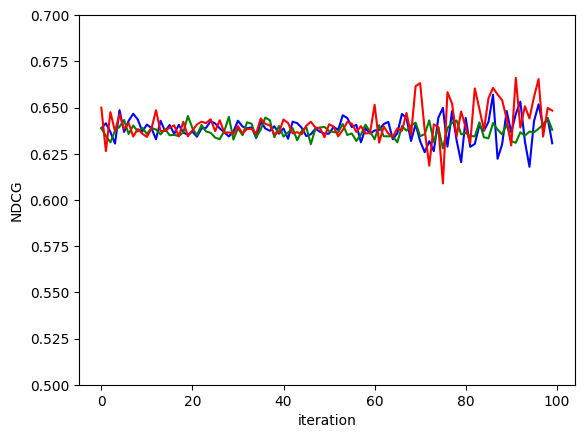

In [12]:
lr_metrics_dict = pd.DataFrame(lr_metrics)
rf_metrics_dict = pd.DataFrame(rf_metrics)
fm_metrics_dict = pd.DataFrame(fm_metrics)
rand_metrics_dict = pd.DataFrame(rnd_metrics)

plt.plot(lr_metrics_dict['NDCG@5'], color='b')
plt.plot(rf_metrics_dict['NDCG@5'], color='g')
plt.plot(fm_metrics_dict['NDCG@5'], color='r')
plt.plot(rand_metrics_dict['NDCG@5'], color='c')
plt.xlabel('iteration')
plt.ylabel('NDCG')
plt.ylim(0.5, 0.7)
plt.savefig('ndcg_als_lr.png', dpi=300)

In [14]:
lr_metrics_dict

,NDCG@5,Precision@5,RocAuc@5
0,0.638790,0.277129,0.496148
1,0.641480,0.269002,0.507749
2,0.636716,0.275860,0.504912
3,0.630504,0.276982,0.484128
4,0.648598,0.275777,0.516536
...,...,...,...
95,0.642637,0.281410,0.503666
96,0.651709,0.275483,0.519319
97,0.639799,0.282113,0.497061
98,0.644189,0.279227,0.500226


In [13]:
rand_metrics_dict

,NDCG@5,Precision@5,RocAuc@5
0,0.782402,0.518865,0.522883
1,0.777479,0.517940,0.516436
2,0.775118,0.516561,0.513977
3,0.775574,0.513800,0.517395
4,0.774003,0.515868,0.513215
...,...,...,...
95,0.777878,0.515042,0.516426
96,0.775513,0.516076,0.515736
97,0.778476,0.517646,0.515733
98,0.775498,0.514527,0.516489
